In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import RandomUnderSampler

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("emotion_sentimen_dataset.csv")


In [3]:
df.drop(df.columns[0], axis=1, inplace=True)


In [4]:
df

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral
...,...,...
839550,i feel like telling these horny devils to find...,neutral
839551,i began to realize that when i was feeling agi...,neutral
839552,i feel very curious be why previous early dawn...,neutral
839553,i feel that becuase of the tyranical nature of...,neutral


In [5]:
df.isnull().sum()

text       0
Emotion    0
dtype: int64

In [6]:
df.describe()

,text,Emotion
count,839555,839555
unique,393822,13
top,i feel more adventurous willing to take risks,neutral
freq,32,674538


In [7]:
df.columns

Index(['text', 'Emotion'], dtype='object')

In [8]:
df.shape

(839555, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     839555 non-null  object
 1   Emotion  839555 non-null  object
dtypes: object(2)
memory usage: 12.8+ MB


In [10]:
df.nunique()

text       393822
Emotion        13
dtype: int64

In [11]:
df['Emotion'].unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

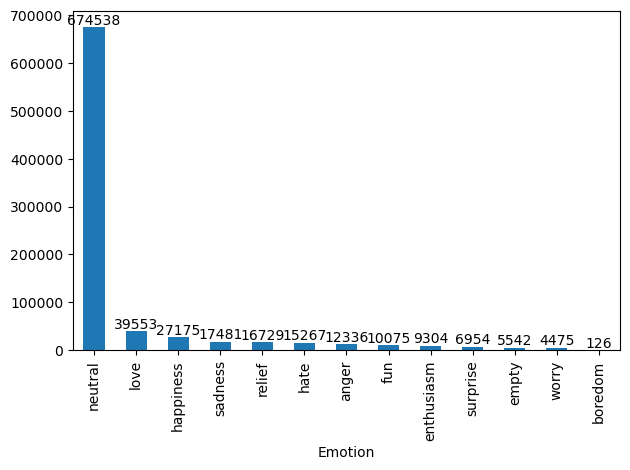

In [12]:
counts = df[df.columns[-1]].value_counts()
fig, axes = plt.subplots()
counts.plot(kind="bar", ax=axes)
for container in axes.containers:
    axes.bar_label(container)
    
plt.tight_layout()
plt.show()

In [13]:
le = LabelEncoder()
df[df.columns[-1]] = le.fit_transform(df[df.columns[-1]].values)

In [14]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(x):
    for txt, _ in x:
        yield tokenizer(txt)
        
vocab = build_vocab_from_iterator(yield_tokens(df.values), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


In [15]:
text_pipeline = lambda x: vocab(tokenizer(x))


In [16]:
def collator(batch):
    texts, labels, offsets = [], [], [0]
    for txt, label in batch:
        text = torch.tensor(text_pipeline(txt), dtype=torch.int64)
        labels.append(label)
        offsets.append(text.size(0))
        texts.append(text)
        
    texts = torch.cat(texts)
    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    if torch.cuda.is_available():
        texts, labels, offsets = texts.cuda(), labels.cuda(), offsets.cuda()
    return texts, labels, offsets


In [17]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

rus = RandomUnderSampler()
x, y = rus.fit_resample(x, y)
data = np.hstack((x, y.reshape(-1, 1)))


In [18]:
train, validation = train_test_split(data, random_state=42, test_size=0.4)
test, val = train_test_split(validation, random_state=42, test_size=0.5)

In [19]:
EPOCHS = 1000
BATCH = 8
LR = 1.0
GAMMA = 0.9
STEP = 100
EM_SIZE = 64
VOCAB_SIZE = len(vocab)
OUT_CLASSES = df[df.columns[-1]].nunique()

In [20]:
train_dl = DataLoader(train, batch_size=BATCH, shuffle=True, collate_fn=collator)
val_dl = DataLoader(val, batch_size=BATCH, shuffle=False, collate_fn=collator)

In [21]:
class EmotionsDetector(nn.Module):
    def __init__(self, vocab_size, em_size, out_classes):
        super(EmotionsDetector, self).__init__()
        self.embed = nn.EmbeddingBag(vocab_size, em_size, sparse=False)
        self.linear = nn.Linear(em_size, 128)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128, out_classes)
        
    def forward(self, x, off):
        x = self.embed(x, off)
        x = self.linear(x)
        x = self.relu(x)
        x = self.fc(x)
        return nn.functional.softmax(x)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [23]:
model = EmotionsDetector(VOCAB_SIZE, EM_SIZE, OUT_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [24]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for text, label, offset in train_dl:
        optimizer.zero_grad()
        out = model(text, offset)
        loss = criterion(out, label)
        diff += loss.item()
        acc += (out.argmax(1) == label).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    with torch.no_grad():
        for text, label, offset in train_dl:
            out = model(text, offset)
            loss = criterion(out, label)
            diff += loss.item()
            acc += (out.argmax(1) == label).sum().item()
            total += out.size(0)
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
    if i%100 == 0:
        print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                    val_loss[-1], val_acc[-1]))
    scheduler.step()

Epochs 100 train loss 0.23951755970898567 acc 0.7708757637474541 val loss 0.23950971835985202 acc 0.7708757637474541
Epochs 200 train loss 0.2383967353952878 acc 0.780040733197556 val loss 0.2383140649669282 acc 0.780040733197556
Epochs 300 train loss 0.23118704241793414 acc 0.8391038696537678 val loss 0.23117687454534402 acc 0.8391038696537678
Epochs 400 train loss 0.23038360191217022 acc 0.845213849287169 val loss 0.23042546683076442 acc 0.845213849287169
Epochs 500 train loss 0.23015002526965014 acc 0.8472505091649695 val loss 0.23015015953184387 acc 0.8472505091649695
Epochs 600 train loss 0.23005250454434553 acc 0.8472505091649695 val loss 0.230052317232804 acc 0.8472505091649695
Epochs 700 train loss 0.2301277433296328 acc 0.8472505091649695 val loss 0.2300870809438515 acc 0.8472505091649695
Epochs 800 train loss 0.22995660479831112 acc 0.8482688391038696 val loss 0.22995603970743245 acc 0.8482688391038696
Epochs 900 train loss 0.2223547546538219 acc 0.9124236252545825 val loss 0

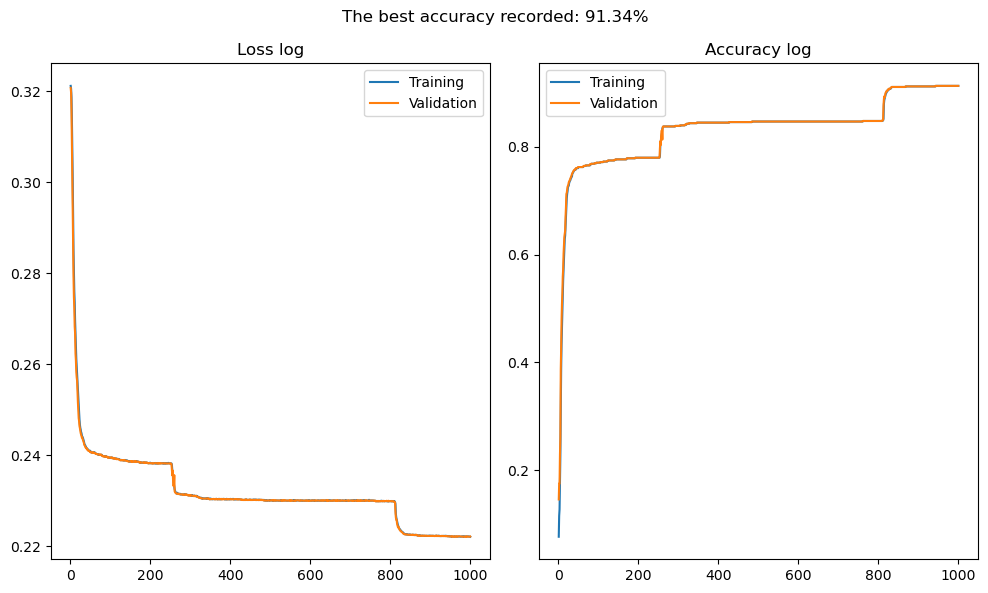

In [25]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.suptitle("The best accuracy recorded: {}%".format(round(best_acc*100, 2)))
plt.tight_layout()
plt.show()

In [26]:
def predict(text):
    txt = torch.cat([torch.tensor(text_pipeline(text), dtype=torch.int64)])
    lb = torch.tensor([0], dtype=torch.int64)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            txt, lb = txt.cuda(), lb.cuda()
            
        out = best_model(txt, lb)
        return out.argmax(1).item()

In [28]:
truth = []
pred = []

for i in range(test.shape[0]):
    truth += [test[i, -1]]
    pred += [predict(test[i, 0])]

              precision    recall  f1-score   support

           0       0.59      0.53      0.56        19
           1       0.67      0.48      0.56        25
           2       0.52      0.52      0.52        25
           3       0.77      0.71      0.74        28
           4       0.21      0.39      0.27        28
           5       0.42      0.24      0.30        21
           6       0.48      0.61      0.54        23
           7       0.52      0.44      0.48        27
           8       0.29      0.32      0.30        25
           9       0.18      0.23      0.20        26
          10       0.62      0.41      0.49        32
          11       0.45      0.45      0.45        22
          12       0.45      0.33      0.38        27

    accuracy                           0.44       328
   macro avg       0.47      0.44      0.45       328
weighted avg       0.48      0.44      0.45       328



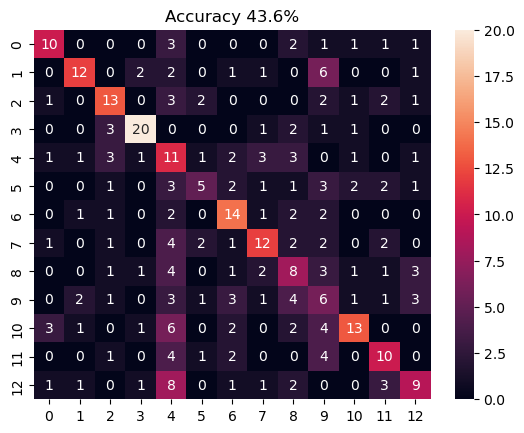

In [29]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
print(report)
sns.heatmap(cm, annot=True)
plt.title("Accuracy {}%".format(round(score*100, 2)))
plt.show()